In [22]:
import os, sys, json, pickle, random
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold

import optuna
from optuna.trial import Trial

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- [0. g-mlp 모듈 경로] --------------------
# GMLP_DIR = "/home/minji/g-mlp"
# if GMLP_DIR not in sys.path:
#     sys.path.append(GMLP_DIR)
# from g_mlp import gMLP # Simple MLP로 대체하므로 주석 처리 또는 삭제


# -------------------- [1. 공통 유틸/환경] --------------------
def set_seed(seed=700):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # 추가: GPU 연산의 무작위성 제거
    if torch.cuda.is_available():
        torch.use_deterministic_algorithms(True)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    else:
        # CPU 환경에서 무작위성 제거
        torch.use_deterministic_algorithms(True, warn_only=True)


set_seed(700)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- [2. 피처 생성 유틸] --------------------
def to_numpy_bitvect(bitvect, n_bits=None, drop_first=False):
    if n_bits is None:
        n_bits = bitvect.GetNumBits()
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(bitvect, arr)
    if drop_first:
        arr = arr[1:]
    return arr.astype(np.float32)

def get_ecfp(mol, radius=2, nbits=1024):
    return to_numpy_bitvect(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits), n_bits=nbits)

def get_maccs(mol):
    bv = MACCSkeys.GenMACCSKeys(mol)
    return to_numpy_bitvect(bv, n_bits=bv.GetNumBits(), drop_first=True)

def get_avalon(mol, nbits=512):
    from rdkit.Avalon import pyAvalonTools
    return to_numpy_bitvect(pyAvalonTools.GetAvalonFP(mol, nbits), n_bits=nbits)

def get_topological_torsion(mol, nbits=1024):
    bv = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nbits)
    return to_numpy_bitvect(bv, n_bits=nbits)

def get_rdkit_desc(mol):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([d[0] for d in Descriptors._descList])
    try:
        descs = calc.CalcDescriptors(mol)
        descs = np.array(descs, dtype=np.float32)
        descs = np.nan_to_num(descs, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        descs = np.zeros(len(Descriptors._descList), dtype=np.float32)
    return descs

def get_rdkit_descriptor_length():
    return len(Descriptors._descList)

# -------------------- [3. 임베딩 로드 & 차원 감지] --------------------
# 함수명과 내부 변수명을 범용적으로 변경 (MolE도 처리 가능하게 함)
def load_molecular_embeddings(embed_paths: dict):
    embed_data, embed_dims = {}, {} # 변수명 변경: scage_embed_dicts -> embed_data, scage_dims -> embed_dims

    for name, path in embed_paths.items():
        try:
            df = pd.read_csv(path)
        except Exception:
            embed_data[name] = {}
            embed_dims[name] = 0
            continue

        def canon(s):
            m = Chem.MolFromSmiles(s)
            return Chem.MolToSmiles(m, canonical=True) if m else None

        df['smiles'] = df['smiles'].apply(canon)
        df = df.dropna(subset=['smiles']).reset_index(drop=True)

        embed_cols = [c for c in df.columns if c != 'smiles']
        dim = len(embed_cols)

        embed_dims[name] = dim  # embed_dims에 차원 저장
        embed_data[name] = {
            row['smiles']: row[embed_cols].to_numpy(dtype=np.float32, copy=False)
            for _, row in df.iterrows()
        }

    return embed_data, embed_dims # 리턴 변수명 변경


# -------------------- [4. 기대 차원 계산 + 안전 결합] --------------------
def compute_expected_dims(fp_types, embed_dims: dict): # <- 인자명 변경: embed_dims 사용
    expected = OrderedDict()
    for t in fp_types:
        if t == 'ecfp':
            expected[t] = 1024
        elif t == 'avalon':
            expected[t] = 512
        elif t == 'maccs':
            expected[t] = 166
        elif t == 'tt':
            expected[t] = 1024
        elif t == 'rdkit':
            expected[t] = get_rdkit_descriptor_length()

        elif 'mole' in t: # <--- MolE 임베딩 추가 (768차원 기본값)
            default_dim = 768
            expected[t] = embed_dims.get(t, default_dim) if embed_dims.get(t, 0) > 0 else default_dim

        elif 'scage' in t: # <--- SCAGE 임베딩 수정 (embed_dims 사용)
            default_dim = 512
            expected[t] = embed_dims.get(t, default_dim) if embed_dims.get(t, 0) > 0 else default_dim

        else:
            raise ValueError(f"Unknown fp_type: {t}")
    return expected

def safe_fit_to_dim(vec: np.ndarray, target_dim: int) -> np.ndarray:
    if vec is None:
        return np.zeros(target_dim, dtype=np.float32)
    vec = vec.astype(np.float32, copy=False)
    if np.any(np.isnan(vec)) or np.any(np.isinf(vec)):
        vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
    cur = vec.shape[0]
    if cur == target_dim:
        return vec
    elif cur < target_dim:
        pad = np.zeros(target_dim - cur, dtype=np.float32)
        return np.concatenate([vec, pad], axis=0)
    else:
        return vec[:target_dim]

# scage_embed_dicts -> embed_dicts 로 인자명 변경
def make_feature_vector(mol, smiles, fp_types, expected_dims, embed_dicts):
    chunks = []
    for t in fp_types:
        dim = expected_dims[t]
        try:
            if t == 'ecfp':
                vec = get_ecfp(mol, radius=2, nbits=dim)
            elif t == 'avalon':
                vec = get_avalon(mol, nbits=dim)
            elif t == 'maccs':
                vec = get_maccs(mol)
            elif t == 'tt':
                vec = get_topological_torsion(mol, nbits=dim)
            elif t == 'rdkit':
                vec = get_rdkit_desc(mol)
            # MolE 포함 모든 임베딩을 embed_dicts에서 조회
            elif 'scage' in t or 'mole' in t:
                vec = embed_dicts.get(t, {}).get(smiles, None)
            else:
                vec = None
        except Exception:
            vec = None
        chunks.append(safe_fit_to_dim(vec, dim))
    feat = np.concatenate(chunks, axis=0)
    feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return feat

# -------------------- [5. Dataset] --------------------
class ScageConcatDataset(data.Dataset):
    # 인자명 변경: scage_paths -> embed_paths
    def __init__(self, label_path, embed_paths: dict, fp_types, expected_dims=None):
        df = pd.read_csv(label_path)
        df = df[['smiles', 'p_np']].rename(columns={'smiles': 'smiles', 'p_np': 'label'})
        df['label'] = df['label'].replace({'BBB-': 0, 'BBB+': 1})
        df = df.drop_duplicates(subset='smiles').reset_index(drop=True)

        # 함수명 변경 및 변수명 변경: load_scage_embeddings -> load_molecular_embeddings
        self.embed_dicts, embed_dims = load_molecular_embeddings(embed_paths)

        if expected_dims is None:
            # embed_dims 전달
            expected_dims = compute_expected_dims(fp_types, embed_dims)
        self.expected_dims = expected_dims
        self.fp_types = list(fp_types)

        def canon(s):
            m = Chem.MolFromSmiles(s)
            return Chem.MolToSmiles(m, canonical=True) if m else None

        df['smiles'] = df['smiles'].apply(canon)
        df = df.dropna(subset=['smiles']).reset_index(drop=True)

        features, labels, failed = [], [], []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating Features"):
            smi = row['smiles']
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                failed.append(smi)
                continue
            # make_feature_vector 호출 시 self.embed_dicts 전달
            feat = make_feature_vector(mol, smi, self.fp_types, self.expected_dims, self.embed_dicts)
            if feat is None or feat.ndim != 1:
                failed.append(smi)
                continue
            features.append(feat)
            labels.append(row['label'])

        self.features = torch.tensor(np.stack(features, axis=0), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.df = df[~df['smiles'].isin(failed)].reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## -------------------- [6. 스플릿 + RDKit 정규화 (토글)] --------------------
def split_then_normalize(
    dataset: ScageConcatDataset,
    split_mode: str = "scaffold",
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    seed: int = 700
):
    set_seed(seed)
    df = dataset.df.copy()

    def get_scaffold(smi):
        m = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(m)) if m else None

    df['scaffold'] = df['smiles'].apply(get_scaffold)
    groups = list(df.groupby('scaffold').groups.values())

    if split_mode == "scaffold":
        groups = sorted(groups, key=lambda g: len(g), reverse=True)
    elif split_mode == "random_scaffold":
        rnd = random.Random(seed)
        rnd.shuffle(groups)
    else:
        raise ValueError("split_mode must be 'scaffold' or 'random_scaffold'")

    n = len(df)
    train_cap = int(round(train_ratio * n))
    val_cap   = int(round(val_ratio   * n))

    train_idx, val_idx, test_idx = [], [], []
    for g in groups:
        g = list(g)
        if len(train_idx) + len(g) <= train_cap:
            train_idx += g
        elif len(val_idx) + len(g) <= val_cap:
            val_idx += g
        else:
            test_idx += g

    def pick(idxs):
        return dataset.features[idxs], dataset.labels[idxs]

    X_train, y_train = pick(train_idx)
    X_val,   y_val   = pick(val_idx)
    X_test,  y_test  = pick(test_idx)

    rd_start, rd_end = None, None
    offset = 0
    for t in dataset.fp_types:
        dim = dataset.expected_dims[t]
        if t == 'rdkit':
            rd_start, rd_end = offset, offset + dim
            break
        offset += dim

    scaler = None
    if rd_start is not None:
        scaler = StandardScaler().fit(X_train[:, rd_start:rd_end])
        X_train[:, rd_start:rd_end] = torch.tensor(scaler.transform(X_train[:, rd_start:rd_end]), dtype=torch.float32)
        X_val[:, rd_start:rd_end]   = torch.tensor(scaler.transform(X_val[:, rd_start:rd_end]),   dtype=torch.float32)
        X_test[:, rd_start:rd_end]  = torch.tensor(scaler.transform(X_test[:, rd_start:rd_end]),  dtype=torch.float32)

    return (
        data.TensorDataset(X_train, y_train),
        data.TensorDataset(X_val,   y_val),
        data.TensorDataset(X_test,  y_test),
        scaler, (rd_start, rd_end),
        (train_idx, val_idx, test_idx)
    )

# -------------------- [7. 모델] --------------------
# gMLP 대신 Simple MLP 클래스 사용
class SimpleMLPFromFlat(nn.Module):
    def __init__(self, mod_dims: OrderedDict, d_hidden=1024, depth=4, dropout=0.2):
        super().__init__()
        self.mod_names = list(mod_dims.keys())
        self.mod_dims = [mod_dims[n] for n in self.mod_names]
        self.in_features = sum(self.mod_dims)
        
        # Simple MLP 구조 정의
        layers = []
        in_dim = self.in_features
        for i in range(depth):
            out_dim = d_hidden
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.GELU()) # GELU 활성화 함수 사용
            layers.append(nn.Dropout(dropout))
            # 다음 레이어의 입력 차원을 현재 레이어의 출력 차원으로 설정
            in_dim = out_dim 
            
        # 분류 헤드 (출력 차원 1)
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, 1)

    def forward(self, x):
        # x는 이미 모든 피처가 결합된 (Batch, Total_Dim) 형태입니다.
        # 모달리티별 분리/토큰화/어텐션/풀링 과정이 필요 없으며, MLP에 바로 입력합니다.
        # 참고: 기존 gMLP에서는 모달리티별로 투영한 후 stack하여 (B, L, D)를 만들었지만,
        # Simple MLP는 (B, Total_Dim)으로 바로 처리합니다.
        
        Xp = self.backbone(x)
        logits = self.head(Xp).squeeze(-1)
        return logits
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## -------------------- [8. 학습/평가 루틴] --------------------
def train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10):
    best_val = float('inf'); best_state = None; bad = 0
    for epoch in range(num_epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                val_loss += loss_fn(model(x), y).item()
        val_loss /= len(val_loader)
        
        if val_loss < best_val:
            best_val = val_loss
            best_state = deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break
    if best_state:
        model.load_state_dict(best_state)
    return model

def eval_model(model, loader):
    model.eval()
    y_true, y_prob, y_pred = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            pred = (probs > 0.5).astype(int)
            y_prob.extend(probs)
            y_pred.extend(pred)
            y_true.extend(y.numpy())
    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = recall_score(y_true, y_pred, zero_division=0)
    else:
        specificity, sensitivity = 0.0, 0.0
    return {
        'accuracy': round(accuracy_score(y_true, y_pred), 3),
        'precision': round(precision_score(y_true, y_pred, zero_division=0), 3),
        'recall': round(sensitivity, 3),
        'f1': round(f1_score(y_true, y_pred, zero_division=0), 3),
        'roc_auc': round(roc_auc_score(y_true, y_prob) if len(set(y_true)) > 1 else 0.0, 3),
        'mcc': round(matthews_corrcoef(y_true, y_pred), 3),
        'sensitivity': sensitivity,
        'specificity': specificity,
    }

# -------------------- [9. 스플릿 인덱스 저장/로드 (SCAGE 공정 비교용)] --------------------
def save_split_indices(out_dir, tag, split_indices):
    os.makedirs(out_dir, exist_ok=True)
    train_idx, val_idx, test_idx = split_indices
    np.save(os.path.join(out_dir, f"train_idx_{tag}.npy"), np.array(train_idx, dtype=np.int64))
    np.save(os.path.join(out_dir, f"val_idx_{tag}.npy"),   np.array(val_idx,   dtype=np.int64))
    np.save(os.path.join(out_dir, f"test_idx_{tag}.npy"),  np.array(test_idx,  dtype=np.int64))

def load_split_indices(path, tag):
    train_idx = np.load(os.path.join(path, f"train_idx_{tag}.npy"))
    val_idx = np.load(os.path.join(path, f"val_idx_{tag}.npy"))
    test_idx = np.load(os.path.join(path, f"test_idx_{tag}.npy"))
    return train_idx, val_idx, test_idx
# -------------------- [10. 구성/스케일러 저장·로드] --------------------
def save_config(cfg_path, config: dict):
    with open(cfg_path, 'w') as f:
        json.dump(config, f, indent=2)

def load_config(cfg_path):
    with open(cfg_path, 'r') as f:
        return json.load(f)

def save_scaler(path, scaler):
    with open(path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

if __name__ == "__main__":
    # (A) 실험 스위치
    split_mode = "random_scaffold" # "scaffold" | "random_scaffold"
    
    # (A-1) 반복 실험을 위한 시드 리스트
    seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    
    # (A-2) 결과를 저장할 리스트
    results = []
    
    # (L) 반복문 시작
    for seed in seeds:
        print("\n" + "="*80)
        print(f"--- [STARTING NEW RUN] Split Mode: {split_mode}, Seed: {seed} ---")
        print("="*80)
        
        # (B) 경로/설정 — BBBP(2039)만 사용
        # 경로 설정은 사용자 환경에 맞게 수정해야 합니다.
        # **주의:** Jupyter Notebook 환경에서는 경로가 다를 수 있습니다.
        label_path = '/home/minji/scage/BBB/bench_label.csv' 
        mole_path = '/home/minji/mole_public/MolE_embed_base_bbb.csv'
        
        embed_paths = {
            'scage1': '/home/minji/scage/BBB/bench_embed.csv',
            'scage2' : '/home/minji/scage/BBB/bench_atom_embed.csv',
            'mole' : mole_path
        }
        # 'mole' 태그를 특징 목록에 추가
        fp_types = ['rdkit', 'scage1', 'mole']

        # (C) Dataset & dims
        dataset = ScageConcatDataset(label_path, embed_paths, fp_types=fp_types)
        expected_dims = dataset.expected_dims
        mod_dims = OrderedDict((t, expected_dims[t]) for t in fp_types)
        
        # Simple MLP의 입력 차원 계산
        total_feature_dim = sum(mod_dims.values())
        print(f"[Info] Total Input Feature Dimension: {total_feature_dim}")

        # (D) Split + RDKit normalize (8:1:1)
        train_ds, val_ds, test_ds, scaler, (rd_start, rd_end), split_indices = split_then_normalize(
            dataset, split_mode=split_mode, train_ratio=0.8, val_ratio=0.1, seed=seed
        )

        # (E) 스플릿 저장(→ SCAGE도 같은 인덱스로 학습/평가 가능)
        split_dir = "./splits_mlp" # 경로 변경
        tag = f"3_final_{split_mode}_seed{seed}"
        save_split_indices(split_dir, tag, split_indices)
        print(f"[Save] split indices -> {split_dir} (tag={tag})")

        # (F) DataLoader
        train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True)
        val_loader   = data.DataLoader(val_ds,   batch_size=128, shuffle=False)
        test_loader  = data.DataLoader(test_ds,  batch_size=128, shuffle=False)
        
        # --- 클래스 분포 분석 및 시각화 ---
        def plot_class_distribution(train_labels, val_labels, test_labels, seed):
            labels_map = {0: 'Negative', 1: 'Positive'}
            train_counts = pd.Series(train_labels).map(labels_map).value_counts(normalize=True).sort_index()
            val_counts = pd.Series(val_labels).map(labels_map).value_counts(normalize=True).sort_index()
            test_counts = pd.Series(test_labels).map(labels_map).value_counts(normalize=True).sort_index()

            counts_df = pd.DataFrame({
                'Train': train_counts,
                'Validation': val_counts,
                'Test': test_counts
            }).fillna(0)

            fig, ax = plt.subplots(figsize=(8, 6))
            counts_df.T.plot(kind='bar', stacked=False, ax=ax, rot=0)
            ax.set_title(f'Class Distribution by Split (Seed: {seed})')
            ax.set_ylabel('Proportion')
            ax.set_xlabel('Dataset Split')
            ax.legend(title='Class')
            plt.tight_layout()
            
            os.makedirs("./artifacts_mlp", exist_ok=True) # 경로 변경
            plt.savefig(f'./artifacts_mlp/class_distribution_{split_mode}_seed{seed}.png')
            plt.close()

        y_train = train_ds.tensors[1].cpu().numpy()
        y_val = val_ds.tensors[1].cpu().numpy()
        y_test = test_ds.tensors[1].cpu().numpy()

        print(f"\n--- [Info] Class distribution for seed {seed} ---")
        print(f"Train: Positive={np.mean(y_train):.2f}, Negative={1-np.mean(y_train):.2f}")
        print(f"Validation: Positive={np.mean(y_val):.2f}, Negative={1-np.mean(y_val):.2f}")
        print(f"Test: Positive={np.mean(y_test):.2f}, Negative={1-np.mean(y_test):.2f}")
        
        plot_class_distribution(y_train, y_val, y_test, seed)

        # (G) Model - Simple MLP로 교체
        set_seed(seed)
        model = SimpleMLPFromFlat(
            mod_dims=mod_dims, 
            d_hidden=1024, # 은닉층 차원 (기존 d_ffn과 유사)
            depth=2,       # 은닉층의 깊이 (기존 gMLP depth와 유사)
            dropout=0.2    # 드롭아웃 비율
        ).to(device)

        print(f"[Info] Simple MLP Parameters: {count_parameters(model)}")
        
        # (H) pos_weight (옵션)
        pos_weight = None
        try:
            n_pos = (y_train == 1).sum()
            n_neg = (y_train == 0).sum()
            if n_pos > 0:
                pos_weight = torch.tensor([max(n_neg / n_pos, 1.0)], dtype=torch.float32, device=device)
                print(f"[Info] Using pos_weight={pos_weight.item():.4f} (neg/pos={n_neg}/{n_pos})")
        except Exception as e:
            print(f"[Warn] pos_weight auto-calc skipped: {e}")

        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()

        # (I) Train
        print(f"--- [STEP 1] Training Simple MLP on BBBP (split_mode={split_mode}) ---")
        model = train_model(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=50, patience=10)
        print("\n--- [STEP 1.5] Evaluating on BBBP Validation Split ---")
        baseline_val_metrics = eval_model(model, val_loader)
        
        # (J) Test eval (== 공식 벤치마크 성능 지표)
        print("\n--- [STEP 2] Evaluating on BBBP Test Split ---")
        metrics = eval_model(model, test_loader)
        print(f"Test Metrics: {metrics}")
        
        # (J-1) 각 시드별 결과 저장
        metrics['seed'] = seed
        metrics['train_pos_ratio'] = np.mean(y_train)
        metrics['val_pos_ratio'] = np.mean(y_val)
        metrics['test_pos_ratio'] = np.mean(y_test)
        results.append(metrics)
        
        # (K) 아티팩트 저장 (모드 태그로 구분)
        os.makedirs("./simple2", exist_ok=True)
        model_path  = f"./simple2/mlp_best_model_{tag}.pth"
        cfg_path    = f"./simple2/feature_config_{tag}.json"
        scaler_path = f"./simple2/rdkit_scaler_{tag}.pkl"
        torch.save(model.state_dict(), model_path)
        cfg = {
            "fp_types": fp_types,
            "mod_dims": {k: int(v) for k, v in mod_dims.items()},
            "total_feature_dim": int(total_feature_dim), # 총 입력 차원 추가
            "rd_slice": [rd_start, rd_end] if rd_start is not None else None,
            "split_mode": split_mode,
            "seed": seed,
            # Simple MLP 하이퍼파라미터로 변경
            "model_hparams": {"d_hidden": 1024, "depth": 2, "dropout": 0.2}, 
            "train_params": {"lr": 1e-4, "weight_decay": 1e-5, "num_epochs": 50, "patience": 10},
            "class_balance": {"n_pos": int(n_pos) if 'n_pos' in locals() else None,
                              "n_neg": int(n_neg) if 'n_neg' in locals() else None,
                              "pos_weight": float(pos_weight.item()) if pos_weight is not None else None}
        }
        save_config(cfg_path, cfg)
        if scaler is not None:
            save_scaler(scaler_path, scaler)
    
    # (M) 최종 결과 요약 및 출력
    print("\n" + "="*80)
    print("--- [FINAL SUMMARY] Simple MLP Average Performance Across 10 Seeds ---")
    print("="*80)
    
    # pandas DataFrame으로 변환하여 평균 계산
    results_df = pd.DataFrame(results).set_index('seed')
    summary = results_df.mean(numeric_only=True)
    std_dev = results_df.std(numeric_only=True)
    
    for metric in summary.index:
        print(f"{metric:<18}| Mean: {summary[metric]:.4f} | Std Dev: {std_dev[metric]:.4f}")
    
    # DataFrame을 CSV 파일로 저장 (선택 사항)
    results_df.to_csv(f"./simple2/final_multi_seed_results_mlp_{split_mode}.csv")
    print(f"\n[Save] Detailed results saved to ./simple2/final_multi_seed_results_mlp_{split_mode}.csv")
    print("="*80)


--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 42 ---


[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not removing hydrogen atom without neighbors
[10:15:15] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not removing hydrogen atom without neighbors
[10:15:27] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed42)

--- [Info] Class distribution for seed 42 ---
Train: Positive=0.75, Negative=0.25
Validation: Positive=0.83, Negative=0.17
Test: Positive=0.79, Negative=0.21
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=403/1228)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.877, 'precision': 0.92, 'recall': 0.926, 'f1': 0.923, 'roc_auc': np.float64(0.922), 'mcc': np.float64(0.622), 'sensitivity': 0.9259259259259259, 'specificity': np.float64(0.6904761904761905)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 100 ---


[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not removing hydrogen atom without neighbors
[10:15:28] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:39] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed100)

--- [Info] Class distribution for seed 100 ---
Train: Positive=0.77, Negative=0.23
Validation: Positive=0.80, Negative=0.20
Test: Positive=0.72, Negative=0.28
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=381/1250)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.843, 'precision': 0.844, 'recall': 0.959, 'f1': 0.898, 'roc_auc': np.float64(0.878), 'mcc': np.float64(0.586), 'sensitivity': 0.9591836734693877, 'specificity': np.float64(0.543859649122807)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 200 ---


[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not removing hydrogen atom without neighbors
[10:15:40] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not removing hydrogen atom without neighbors
[10:15:52] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed200)

--- [Info] Class distribution for seed 200 ---
Train: Positive=0.76, Negative=0.24
Validation: Positive=0.79, Negative=0.21
Test: Positive=0.75, Negative=0.25
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=387/1244)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.843, 'precision': 0.872, 'recall': 0.929, 'f1': 0.899, 'roc_auc': np.float64(0.903), 'mcc': np.float64(0.551), 'sensitivity': 0.9285714285714286, 'specificity': np.float64(0.58)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 300 ---


[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not removing hydrogen atom without neighbors
[10:15:53] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not removing hydrogen atom without neighbors
[10:16:04] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed300)

--- [Info] Class distribution for seed 300 ---
Train: Positive=0.77, Negative=0.23
Validation: Positive=0.77, Negative=0.23
Test: Positive=0.75, Negative=0.25
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=380/1251)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.868, 'precision': 0.898, 'recall': 0.928, 'f1': 0.913, 'roc_auc': np.float64(0.926), 'mcc': np.float64(0.642), 'sensitivity': 0.9276315789473685, 'specificity': np.float64(0.6923076923076923)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 400 ---


[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not removing hydrogen atom without neighbors
[10:16:05] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed400)

--- [Info] Class distribution for seed 400 ---
Train: Positive=0.77, Negative=0.23
Validation: Positive=0.69, Negative=0.31
Test: Positive=0.81, Negative=0.19
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=376/1255)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.868, 'precision': 0.916, 'recall': 0.921, 'f1': 0.918, 'roc_auc': np.float64(0.914), 'mcc': np.float64(0.568), 'sensitivity': 0.9212121212121213, 'specificity': np.float64(0.6410256410256411)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 500 ---


[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:17] WARNING: not removing hydrogen atom without neighbors
[10:16:18] WARNING: not removing hydrogen atom without neighbors
[10:16:18] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not removing hydrogen atom without neighbors
[10:16:29] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed500)

--- [Info] Class distribution for seed 500 ---
Train: Positive=0.77, Negative=0.23
Validation: Positive=0.75, Negative=0.25
Test: Positive=0.72, Negative=0.28
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=370/1261)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.863, 'precision': 0.888, 'recall': 0.925, 'f1': 0.906, 'roc_auc': np.float64(0.944), 'mcc': np.float64(0.654), 'sensitivity': 0.9246575342465754, 'specificity': np.float64(0.7068965517241379)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 600 ---


[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not removing hydrogen atom without neighbors
[10:16:30] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed600)

--- [Info] Class distribution for seed 600 ---
Train: Positive=0.76, Negative=0.24
Validation: Positive=0.76, Negative=0.24
Test: Positive=0.82, Negative=0.18
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=394/1237)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.877, 'precision': 0.923, 'recall': 0.928, 'f1': 0.925, 'roc_auc': np.float64(0.905), 'mcc': np.float64(0.583), 'sensitivity': 0.9281437125748503, 'specificity': np.float64(0.6486486486486487)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 700 ---


[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not removing hydrogen atom without neighbors
[10:16:42] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not removing hydrogen atom without neighbors
[10:16:54] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed700)

--- [Info] Class distribution for seed 700 ---
Train: Positive=0.77, Negative=0.23
Validation: Positive=0.78, Negative=0.22
Test: Positive=0.70, Negative=0.30
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=373/1258)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.755, 'precision': 0.769, 'recall': 0.93, 'f1': 0.842, 'roc_auc': np.float64(0.816), 'mcc': np.float64(0.35), 'sensitivity': 0.9300699300699301, 'specificity': np.float64(0.3442622950819672)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 800 ---


[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not removing hydrogen atom without neighbors
[10:16:55] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not removing hydrogen atom without neighbors
[10:17:06] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed800)

--- [Info] Class distribution for seed 800 ---
Train: Positive=0.76, Negative=0.24
Validation: Positive=0.75, Negative=0.25
Test: Positive=0.83, Negative=0.17
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=392/1239)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.882, 'precision': 0.91, 'recall': 0.953, 'f1': 0.931, 'roc_auc': np.float64(0.859), 'mcc': np.float64(0.551), 'sensitivity': 0.9526627218934911, 'specificity': np.float64(0.5428571428571428)}

--- [STARTING NEW RUN] Split Mode: random_scaffold, Seed: 900 ---


[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not removing hydrogen atom without neighbors
[10:17:07] WARNING: not r

[Info] Total Input Feature Dimension: 1497


[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not removing hydrogen atom without neighbors
[10:17:19] WARNING: not r

[Save] split indices -> ./splits_mlp (tag=3_final_random_scaffold_seed900)

--- [Info] Class distribution for seed 900 ---
Train: Positive=0.76, Negative=0.24
Validation: Positive=0.76, Negative=0.24
Test: Positive=0.82, Negative=0.18
[Info] Simple MLP Parameters: 2584577
[Info] Using pos_weight=1.0000 (neg/pos=393/1238)
--- [STEP 1] Training Simple MLP on BBBP (split_mode=random_scaffold) ---

--- [STEP 1.5] Evaluating on BBBP Validation Split ---

--- [STEP 2] Evaluating on BBBP Test Split ---
Test Metrics: {'accuracy': 0.912, 'precision': 0.946, 'recall': 0.946, 'f1': 0.946, 'roc_auc': np.float64(0.952), 'mcc': np.float64(0.703), 'sensitivity': 0.9461077844311377, 'specificity': np.float64(0.7567567567567568)}

--- [FINAL SUMMARY] Simple MLP Average Performance Across 10 Seeds ---
accuracy          | Mean: 0.8588 | Std Dev: 0.0415
precision         | Mean: 0.8886 | Std Dev: 0.0509
recall            | Mean: 0.9345 | Std Dev: 0.0131
f1                | Mean: 0.9101 | Std Dev: 0.0281
r

[Info] Loaded Feature Types: ['rdkit', 'scage1', 'mole']
[Info] MLP Hyperparameters: {'d_hidden': 1024, 'depth': 2, 'dropout': 0.2}


[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:43] WARNING: not removing hydrogen atom without neighbors
[10:34:44] Unusual charge on atom 42 number of radical electrons set to zero
[10:34:48] WARNING: not removing hydrogen atom without neighbors
[10:34:48] WARNING: not removing hydrogen atom without neighbors
[10:34:48] WARNING: not removing hydrogen atom without neighbors
[10:34:48] WARNING: not removing hydrogen atom without neighbors
[10:34:48] WARNING: not removing hydrogen atom without neighbors
[10:34:48] WARNING: not removing hydrogen atom without neighbors
[10:34:48] WA

--- Starting Soft Voting Inference on Simple MLP Models ---
New Data Samples: 12361
Split Mode: scaffold
✅ Seed 42 Simple MLP prediction successful.
✅ Seed 100 Simple MLP prediction successful.
✅ Seed 200 Simple MLP prediction successful.
✅ Seed 300 Simple MLP prediction successful.


/tmp/ipykernel_497614/3844801397.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
/tmp/ipykernel_49761

✅ Seed 400 Simple MLP prediction successful.
✅ Seed 500 Simple MLP prediction successful.
✅ Seed 600 Simple MLP prediction successful.
✅ Seed 700 Simple MLP prediction successful.
✅ Seed 800 Simple MLP prediction successful.


/tmp/ipykernel_497614/3844801397.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


✅ Seed 900 Simple MLP prediction successful.

--- Soft Voting Ensemble Performance (Simple MLP Models on New Data) ---
Models used: 10 / 10
Accuracy:      0.754
Precision:     0.852
Recall (Sens.):0.770
Specificity:   0.721
F1-score:      0.809
ROC-AUC:       0.836
MCC:           0.471

Confusion Matrix:
[[2885 1114]
 [1926 6436]]


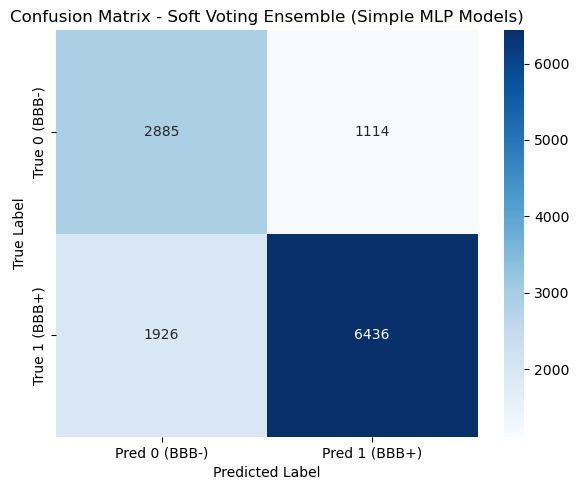


✅ Soft voting ensemble 결과 저장 완료 → ./simple2/mlp_new_bbb_predictions_soft_ensemble_scaffold.csv


In [23]:
import pandas as pd
import numpy as np
import os
import torch
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)
# 주의: load_config, load_scaler, SimpleMLPFromFlat, 
# ScageConcatDataset, eval_model 등의 함수/클래스는 상단에 정의되어 있어야 합니다.

# -------------------- [앙상블 추론 및 평가 설정] --------------------
seeds = [42, 100, 200, 300, 400, 500, 600, 700, 800, 900]
# ⚠️ 주의: 이전 셀에서 학습 시 사용한 split_mode와 동일하게 설정해야 합니다.
# 이전 셀에서 'random_scaffold'를 사용했으므로, 여기도 'random_scaffold'로 설정
split_mode = "scaffold" # <-- 학습 시 사용된 split_mode로 변경해야 합니다.

# 🌟 수정 1: 아티팩트 기본 경로를 Simple MLP 모델이 저장된 경로로 변경
base_dir = "./simple2" # <-- MLP 아티팩트 저장 경로

# 🌟 수정 2: 아티팩트 파일 태그 접두사를 학습 시 사용한 것으로 변경
tag_prefix = "3_final" 

# 새 데이터 경로 설정 (이전 셀에서 사용된 경로를 재사용)
NEW_LABEL_PATH = "/home/minji/scage/BBB/my_label.csv"
NEW_EMBED_PATHS = {
    'scage1': '/home/minji/scage/BBB/my_embed.csv',
    # 'scage2'는 MLP 학습 시 사용되지 않았으므로 생략 또는 무시됨
    'mole': '/home/minji/mole_public/MolE_embed_base_my.csv'
}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- [1. 공통 특징 및 설정 로드] --------------------
# 특징 타입과 차원 정보를 얻기 위해 시드 42의 설정 로드 (모든 시드에서 동일)
try:
    CONFIG_42_PATH = f"{base_dir}/feature_config_{tag_prefix}_{split_mode}_seed42.json"
    config_42 = load_config(CONFIG_42_PATH)
    mod_dims = OrderedDict(config_42['mod_dims'])
    fp_types = config_42['fp_types']
    rd_slice_info = config_42['rd_slice']
    # 앙상블에 사용될 모델의 하이퍼파라미터 정보도 미리 확인
    mlp_hparams_template = config_42['model_hparams']
    print(f"[Info] Loaded Feature Types: {fp_types}")
    print(f"[Info] MLP Hyperparameters: {mlp_hparams_template}")
except FileNotFoundError:
    print(f"🚨 에러: 초기 설정 파일 ({CONFIG_42_PATH})이 누락되었습니다. MLP 실행을 확인하세요.")
    raise

# 새 데이터셋 특징 생성 (Soft Voting을 위해 라벨/SMILES 구조를 유지)
# NOTE: fp_types에 포함되지 않은 'scage2' 임베딩은 자동으로 무시됩니다.
new_dataset_raw = ScageConcatDataset(NEW_LABEL_PATH, NEW_EMBED_PATHS, fp_types, expected_dims=mod_dims)
raw_features = new_dataset_raw.features.clone()
raw_df = new_dataset_raw.df[['smiles', 'label']].copy()
dfs = []


# -------------------- [2. 시드별 예측 수행 및 저장] --------------------
print("="*80)
print("--- Starting Soft Voting Inference on Simple MLP Models ---")
print(f"New Data Samples: {len(raw_df)}")
print(f"Split Mode: {split_mode}")
print("="*80)

for seed in seeds:
    artifact_tag = f"{tag_prefix}_{split_mode}_seed{seed}"
    
    # 파일 경로 정의
    cfg_path    = f"{base_dir}/feature_config_{artifact_tag}.json"
    model_path  = f"{base_dir}/mlp_best_model_{artifact_tag}.pth" # 🌟 모델 파일명 변경
    scaler_path = f"{base_dir}/rdkit_scaler_{artifact_tag}.pkl"

    try:
        # A. 설정 및 스케일러 로드
        cfg = load_config(cfg_path)
        hparams = cfg['model_hparams'] # d_hidden, depth, dropout 등이 포함됨
        scaler = load_scaler(scaler_path) if os.path.exists(scaler_path) else None
        
        # B. 모델 초기화 및 가중치 로드
        # 🌟 모델 클래스를 SimpleMLPFromFlat으로 변경 및 MLP 하이퍼파라미터 사용
        model = SimpleMLPFromFlat(
            mod_dims=mod_dims,
            d_hidden=hparams['d_hidden'],
            depth=hparams['depth'],
            dropout=hparams['dropout']
        ).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        # C. 데이터 복제 및 정규화 적용 (시드별 Scaler 적용)
        X_pred = raw_features.clone()
        if rd_slice_info is not None and scaler is not None:
            rd_start, rd_end = rd_slice_info
            X_pred[:, rd_start:rd_end] = torch.tensor(
                scaler.transform(X_pred[:, rd_start:rd_end].cpu().numpy()), 
                dtype=torch.float32
            )
            
        # D. 예측 수행
        with torch.no_grad():
            X_tensor = X_pred.to(DEVICE)
            logits = model(X_tensor)
            probs = torch.sigmoid(logits).cpu().numpy()
        
        # E. 결과 정리 및 리스트에 추가
        df_result = raw_df[['smiles', 'label']].copy()
        df_result[f'prob_{seed}'] = probs
        dfs.append(df_result)
        print(f"✅ Seed {seed} Simple MLP prediction successful.")
        
    except FileNotFoundError:
        print(f"⚠️ 경고: Seed {seed}의 아티팩트 파일이 누락되어 건너뜁니다. ({cfg_path})")
    except Exception as e:
        print(f"❌ 에러: Seed {seed} 모델 로드/예측 중 오류 발생: {e}")


# -------------------- [3. Soft Voting 앙상블 및 평가] --------------------
if len(dfs) < 2:
    print("❌ 앙상블을 수행하기에 충분한 모델이 로드되지 않았습니다. (최소 2개 모델 필요)")
else:
    # A. smiles/label 기준으로 병합
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on=['smiles', 'label'], how='inner')

    # B. Soft Voting (확률 평균)
    prob_cols = [col for col in merged.columns if col.startswith('prob_')]
    merged['ensemble_prob'] = merged[prob_cols].mean(axis=1)
    merged['ensemble_pred'] = (merged['ensemble_prob'] > 0.5).astype(int)

    # C. 성능 평가
    y_true = merged['label']
    y_pred = merged['ensemble_pred']
    y_prob = merged['ensemble_prob']

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Specificity 계산
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    else:
        specificity = 0.0 # 클래스가 하나만 있을 경우

    # D. 결과 출력
    print("\n" + "="*80)
    print("--- Soft Voting Ensemble Performance (Simple MLP Models on New Data) ---") # 🌟 제목 변경
    print("="*80)
    print(f"Models used: {len(prob_cols)} / {len(seeds)}")
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision:     {prec:.3f}")
    print(f"Recall (Sens.):{rec:.3f}")
    print(f"Specificity:   {specificity:.3f}")
    print(f"F1-score:      {f1:.3f}")
    print(f"ROC-AUC:       {auc:.3f}")
    print(f"MCC:           {mcc:.3f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    # E. Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0 (BBB-)', 'Pred 1 (BBB+)'],
                yticklabels=['True 0 (BBB-)', 'True 1 (BBB+)'])
    plt.title("Confusion Matrix - Soft Voting Ensemble (Simple MLP Models)") # 🌟 제목 변경
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # F. 결과 저장
    save_path = f"{base_dir}/mlp_new_bbb_predictions_soft_ensemble_{split_mode}.csv" # 🌟 파일명 변경
    merged.to_csv(save_path, index=False)
    print(f"\n✅ Soft voting ensemble 결과 저장 완료 → {save_path}")